# Generating animated time series using xr_animation <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[s2a_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_ard_granule), 
[s2b_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_ard_granule)

## Background
Animations can be a powerful method for visualising change in the landscape across time using satellite imagery. Satellite data from Digital Earth Australia is an ideal subject for animations as it has been georeferenced, processed to analysis-ready surface reflectance, and stacked into a spatio-temporal 'data cube', allowing landscape conditions to be extracted and  visualised consistently across time.

Using the `xr_animation` function from `dea_plotting`, we can take a time series of Digital Earth Australia satellite imagery and export a visually appealing time series animation that shows how any location in Australia has changed over the past 30+ years.

## Description
This notebook demonstrates how to:

1. Import a time series of cloud-free satellite imagery from multiple satellites (i.e. Sentinel-2A and 2B) as an `xarray` dataset
2. Plot the data as a three band time series animation 
3. Plot the data as a one band time series animation
3. Export the resulting animations as either a GIF or MP4 file
4. Add custom vector overlays
5. Apply custom image processing functions to each animation frame

***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages

In [1]:
%matplotlib inline

import sys
import datacube
import skimage.exposure
import geopandas as gpd
import matplotlib.pyplot as plt
from IPython.display import Image

sys.path.append('../Scripts')
from dea_plotting import rgb
from dea_bandindices import calculate_indices
from dea_datahandling import load_ard
from dea_plotting import xr_animation


### Connect to the datacube

In [2]:
dc = datacube.Datacube(app='Animated_timeseries')

## Load satellite data from datacube
We can use the `load_ard` function to load data from multiple satellites (i.e. Sentinel-2A and -2B), and return a single `xarray.Dataset` containing only observations with a minimum percentage of good quality pixels. 
This will allow us to create a visually appealing time series animation of observations that are not affected by cloud.

In the example below, we request that the function returns only observations which are 95% free of clouds and other poor quality pixels by specifyinge `min_gooddata=0.95`.

In [3]:
# Set up a datacube query to load data for
query = {'x': (142.41, 142.57),  
         'y': (-32.225, -32.325),
         'time': ('2018-09-01', '2019-09-01'),
         'measurements': ['nbart_red', 
                          'nbart_green', 
                          'nbart_blue',
                          'nbart_nir_1',
                          'nbart_swir_2'],
         'output_crs': 'EPSG:3577',
         'resolution': (-30, 30)}

# Load available data from both Sentinel 2 satellites
ds = load_ard(dc=dc, 
              products=['s2a_ard_granule', 's2b_ard_granule'], 
              min_gooddata=0.95,
              mask_pixel_quality=False,
              group_by='solar_day',
              **query)


Finding datasets
    s2a_ard_granule
    s2b_ard_granule
Counting good quality pixels for each time step
Filtering to 19 out of 68 time steps with at least 95.0% good quality pixels
Loading 19 time steps


To get a quick idea of what the data looks like, we can plot a selection of observations from the dataset in true colour using the `rgb` function:

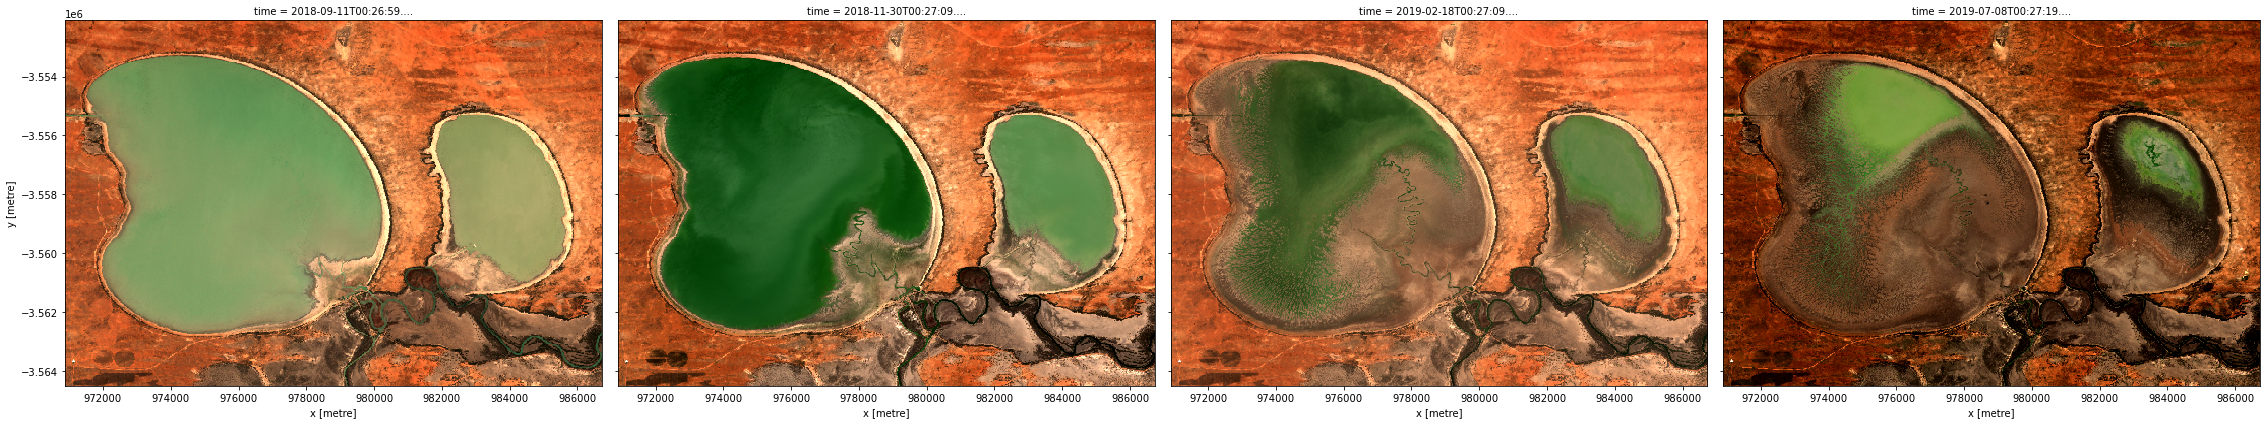

In [4]:
# Plot four images from the dataset
rgb(ds, index=[0, 6, 12, 18])


## Plot time series as a RGB/three band animated GIF
The `xr_animation` function is based on functionality within `matplotlib.animation`. 
It takes an `xarray.Dataset` and exports a one band or three band (e.g. true or false colour) GIF or MP4 animation showing changes in the landscape across time. 

Here, we plot the dataset we loaded above as an animated GIF, using the `['nbart_red', 'nbart_green', 'nbart_blue']` satellite bands to generate a true colour RGB animation.  
The interval between the animation frames is set to to 100 milliseconds using `interval`, and the width of the animation to 300 pixels using `width_pixels`:

Exporting animation to animated_timeseries.gif


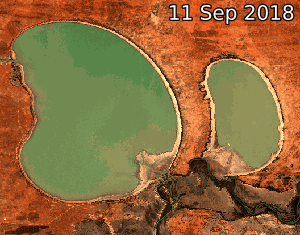

In [5]:
# Produce time series animation of red, green and blue bands
xr_animation(ds=ds, 
             bands=['nbart_red', 'nbart_green', 'nbart_blue'],
             output_path='animated_timeseries.gif',                                
             interval=100, 
             width_pixels=300)

# Plot animated gif
plt.close()
Image(filename='animated_timeseries.gif')


We can also use different band combinations (e.g. false colour) using `bands`, add additional text using `show_text`, and change the font size using `annotation_kwargs`, which passes a dictionary of values to the matplotlib `plt.annotate` function (see [matplotlib.pyplot.annotate](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.annotate.html) for options).

The function will automatically select an appropriate colour stretch by clipping the data to remove outliers/extreme values smaller or greater than the 2 and 98th percentiles (e.g. similar to `xarray`'s `robust=True`).
This can be controlled further with the `percentile_stretch` parameter.
For example, setting `percentile_stretch=(0.01, 0.99)` will apply a colour stretch with less contrast:

In [ ]:
# Produce time series animation of red, green and blue bands
xr_animation(ds=ds,
             bands=['nbart_swir_2', 'nbart_nir_1', 'nbart_green'], 
             output_path='animated_timeseries.gif', 
             width_pixels=300,
             show_text='Time-series animation',
             percentile_stretch=(0.01, 0.99),
             annotation_kwargs={'fontsize': 25}) 

# Plot animated gif
plt.close()
Image(filename='animated_timeseries.gif')

### Plotting single band animations
It is also possible to create a single band animation. 
For example, we could plot an index like the Normalized Difference Water Index (NDWI), which has high values where a pixel is likely to be open water (e.g. NDWI > 0).
In the example below, we calculate NDWI using the `calculate_indices` function from the `DEA_bandindices` script.

(By default the colour bar limits are optimised based on `percentile_stretch`; set `percentile_stretch=(0.00, 1.00)` to show the full range of values from min to max)

Exporting animation to animated_timeseries.gif


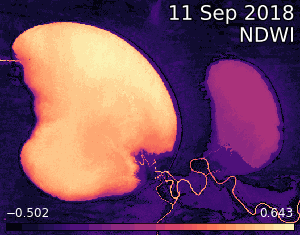

In [6]:
# Compute NDWI; `collection='ga_s2_1'` ensures the correct formula 
# is applied to our Sentinel-2 data
ds = calculate_indices(ds, index='NDWI', collection='ga_s2_1')

# Produce time series animation of NDWI:
xr_animation(ds=ds, 
             output_path='animated_timeseries.gif',
             bands='NDWI', 
             show_text='NDWI', 
             width_pixels=300) 

# Plot animated gif
plt.close()
Image(filename='animated_timeseries.gif')

We can customise single band animations by specifying parameters using `imshow_kwargs`, which is passed to the matplotlib `plt.imshow` function (see https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html for options). 
For example, we can use a more appropriate blue colour scheme with `'cmap': 'Blues'`, and set `'vmin': 0.0, 'vmax': 0.5` to overrule the default colour bar limits:

Exporting animation to animated_timeseries.gif


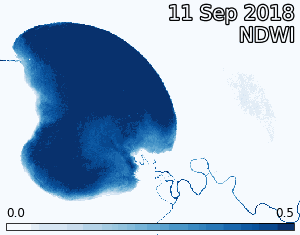

In [7]:
# Produce time series animation using a custom colour scheme and limits:
xr_animation(ds=ds,
             bands='NDWI', 
             output_path='animated_timeseries.gif',
             width_pixels=300,
             show_text='NDWI',
             imshow_kwargs={'cmap': 'Blues', 'vmin': 0.0, 'vmax': 0.5},
             colorbar_kwargs={'colors': 'black'})

# Plot animated gif
plt.close()
Image(filename='animated_timeseries.gif')


One band animations show a colour bar by default, but this can be disabled using `show_colorbar`:

In [ ]:
# Produce time series animation without a colour bar:
xr_animation(ds=ds,
             bands='NDWI', 
             output_path='animated_timeseries.gif',
             width_pixels=300,
             show_text='NDWI',
             show_colorbar=False,
             imshow_kwargs={'cmap': 'Blues', 'vmin': 0.0, 'vmax': 0.5})

# Plot animated gif
plt.close()
Image(filename='animated_timeseries.gif')


### Available output formats
The above examples have focused on exporting animated GIFs, but MP4 files can also be generated. 
The two formats have their own advantages and disadvantages:

* `.mp4`: fast to generate, smallest file sizes and highest quality; suitable for Twitter/social media and recent versions of Powerpoint
* `.gif`: slow to generate, large file sizes, low rendering quality; suitable for all versions of Powerpoint and Twitter/social media
    
> **Note:** To preview a `.mp4` file from within JupyterLab, find the file (e.g. 'animated_timeseries.mp4') in the file browser on the left, right click, and select 'Open in New Browser Tab'.
    
    

In [ ]:
# Animate datasets as a MP4 file
xr_animation(ds=ds, 
             bands=['nbart_red', 'nbart_green', 'nbart_blue'],
             output_path='animated_timeseries.mp4')

## Advanced

### Adding vector overlays
The animation code supports plotting vector files (e.g. ESRI Shapefiles or GeoJSON) over the top of satellite imagery. 
To do this, we first load the file using `geopandas`, and pass this to `xr_animation` using the `show_gdf` parameter.

The sample data we use here provides the spatial extent of water in Lake Pamamaroo (the left lake above) for four dates in 2018-19 (Sep 2018, Nov 2018, Feb 2019, July 2019):

In [ ]:
# Get shapefile path
poly_gdf = gpd.read_file('../Supplementary_data/Animated_timeseries/vector.geojson')

# Produce time series animation 
xr_animation(ds=ds, 
             bands=['nbart_red', 'nbart_green', 'nbart_blue'],
             output_path='animated_timeseries.gif', 
             width_pixels=300,
             show_gdf=poly_gdf) 

# Plot animated gif
plt.close()
Image(filename='animated_timeseries.gif')


You can customise styling for vector overlays by including a column called `'color'` in the `geopandas.GeoDataFrame` object.
For example, to plot the vector in red:

In [ ]:
# Assign a colour to the GeoDataFrame
poly_gdf['color'] = 'red'

# Produce time series animation 
xr_animation(ds=ds, 
             bands=['nbart_red', 'nbart_green', 'nbart_blue'],
             output_path='animated_timeseries.gif', 
             width_pixels=300,
             show_gdf=poly_gdf) 

# Plot animated gif
plt.close()
Image(filename='animated_timeseries.gif')


It can also be useful to focus on our vector outline so that it can provide a useful reference point over the top of our imagery.
To do this, we can assign our shapefile a semi-transparent colour (in this case, blue), and give them a blue outline using the `gdf_kwargs` parameter. This allows us to see all four waterbody features in our vector dataset:

> **Note:** To make a vector completely transparent, set its colour to 'None'.

In [ ]:
# Assign a semi-transparent colour to the GeoDataFrame
poly_gdf['color'] = '#0066ff26'

# Produce time series animation 
xr_animation(ds=ds, 
             bands=['nbart_red', 'nbart_green', 'nbart_blue'],
             output_path='animated_timeseries.gif', 
             width_pixels=300,
             show_gdf=poly_gdf,
             gdf_kwargs={'edgecolor': 'blue'}) 

# Plot animated gif
plt.close()
Image(filename='animated_timeseries.gif')


### Plotting vectors by time
It can be useful to plot vector features over the top of imagery at specific times in an animation.
For example, we may want to plot our four waterbody features at specific times that match up with our imagery so we can visualise how our lake changed in size over time.

To do this, we can create new `start_time` and `end_time` columns in our `geopandas.GeoDataFrame` that tell `xr_animation` when to plot each feature over the top of our imagery:

> **Note**: Dates can be provided in any string format that can be converted using the [pandas.to_datetime()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html). For example, `'2009'`, `'2009-11'`, `'2009-11-01'` etc.
The `start_time` and `end_time` columns are both optional, and will default to the first and last timestep in the animation respectively if not provided.


In [ ]:
# Assign start and end times to each feature
poly_gdf['start_time'] = ['2018-09', '2018-11', '2019-02', '2019-07']
poly_gdf['end_time'] = ['2018-11', '2019-02', '2019-07', '2019-12']

# Preview the updated geopandas.GeoDataFrame
poly_gdf

We can now pass the updated `geopandas.GeoDataFrame` to `xr_animation`:

In [ ]:
# Produce time series animation 
xr_animation(ds=ds, 
             bands=['nbart_red', 'nbart_green', 'nbart_blue'],
             output_path='animated_timeseries.gif', 
             width_pixels=300,
             show_gdf=poly_gdf,
             gdf_kwargs={'edgecolor': 'blue'}) 

# Plot animated gif
plt.close()
Image(filename='animated_timeseries.gif')


### Custom image processing functions

The `image_proc_funcs` parameter allows you to pass custom image processing functions that will be applied to each frame of your animation as they are rendered. 
This can be a powerful way to produce visually appealing animations - some example applications include:

* Improving brightness, saturation or contrast
* Sharpening your images
* Histogram matching or equalisation

To demonstrate this, we will apply two functions from the [skimage.exposure](`https://scikit-image.org/docs/dev/api/skimage.exposure.html`) module which contains many powerful image processing algorithms:

1. `skimage.exposure.rescale_intensity` will first scale our data between 0.0 and 1.0 (required for step 2)
2. `skimage.exposure.equalize_adapthist` will take this re-scaled data and apply an alogorithm that will enhance and contrast local details of the image

> **Note:** Functions supplied to `image_proc_funcs` are applied one after another to each timestep in `ds` (e.g. each frame in the animation). 
Any custom function can be supplied to `image_proc_funcs`, providing it both **accepts and outputs** a `numpy.ndarray` with a shape of `(y, x, bands)`.

In [ ]:
from skimage.filters import unsharp_mask
import numpy as np

# Aniamte data after applying custom image processing functions to each frame
xr_animation(ds=ds, 
             bands=['nbart_red', 'nbart_green', 'nbart_blue'],
             output_path='animated_timeseries.gif',                                
             image_proc_funcs=[skimage.exposure.rescale_intensity,                               
                               skimage.exposure.equalize_adapthist])

# Plot animated gif
plt.close()
Image(filename='animated_timeseries.gif')


---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** April 2020

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)